In [16]:
import copy
import re
from dataclasses import dataclass
from functools import lru_cache
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd

from alns import ALNS, State
from alns.criteria import HillClimbing
from alns.weight_schemes import SegmentedWeights

import pandas as pd
import itertools
from itertools import product
from mip import Model, xsum, BINARY
import os, glob

In [22]:
SEED = 5432

@lru_cache(32)
def schedule(jobs: Tuple[int]) -> Tuple[np.ndarray, np.ndarray]:
    """
    Computes a serial schedule of the given list of jobs. See Figure 1
    in Fleszar and Hindi (2004) for the algorithm. Returns the schedule,
    and the resources used.

    Fleszar, K. and K.S. Hindi. 2004. Solving the resource-constrained
    project scheduling problem by a variable neighbourhood search.
    _European Journal of Operational Research_. 155 (2): 402 -- 413.
    """
    used = np.zeros((instance.duration.sum(), instance.num_resources))
    sched = np.zeros(instance.num_jobs, dtype=int)

    for job in jobs:
        pred = instance.predecessors[job]
        t = max(sched[pred] + instance.duration[pred], default=0)

        needs = instance.needs[job]
        duration = instance.duration[job]

        # This efficiently determines the first feasible insertion point
        # after t. We compute whether resources are available, and add the
        # offset s of the first time sufficient are available for the
        # duration of the job.
        res_ok = np.all(used[t:] + needs <= instance.resources, axis=1)
        for s in np.flatnonzero(res_ok):
            if np.all(res_ok[s:s + duration]):
                sched[job] = t + s
                used[t + s:t + s + duration] += needs
                break

    return sched, used[:sched[instance.last_job]]

@dataclass
class RcpspState(State):
    """
    Solution state for the resource-constrained project scheduling problem.

    We use a list representation of the scheduled jobs, where job i is
    scheduled before j if i precedes j (i.e., the jobs are sorted
    topologically).
    """
    jobs: List[int]

    def __copy__(self):
        return RcpspState(self.jobs.copy())

    @property
    def indices(self) -> np.ndarray:
        """
        Returns a mapping from job -> idx in the schedule. Unscheduled
        jobs have index +inf.
        """
        indices = np.full(instance.num_jobs, np.inf, dtype=int)

        for idx, job in enumerate(self.jobs):
            indices[job] = idx

        return indices

    @property
    def unscheduled(self) -> List[int]:
        """
        All jobs that are not currently scheduled, in topological order.
        """
        return sorted(set(range(instance.num_jobs)) - set(self.jobs))

    def objective(self) -> int:
        s, _ = schedule(tuple(self.jobs))
        return s[instance.last_job]

    def plot(self):
        """
        Plots the current schedule. The plot includes a Gantt chart, the
        lower and upper bounds on an optimal makespan, and bar charts for
        resource use.
        """
        fig = plt.figure(figsize=(12, 6 + instance.num_resources))

        hr = [1] * (instance.num_resources + 1)
        hr[0] = 6

        gs = plt.GridSpec(nrows=1 + instance.num_resources,
                          ncols=1,
                          height_ratios=hr)

        s, u = schedule(tuple(self.jobs))
        idcs = np.argsort(s)

        gantt = fig.add_subplot(gs[0, 0])
        gantt.axvspan(LB, UB, alpha=0.25, color='grey')
        gantt.barh(np.arange(instance.num_jobs),
                   instance.duration[idcs],
                   left=s[idcs])

        gantt.set_xlim(0, self.objective())
        gantt.set_ylim(0, instance.last_job)
        gantt.invert_yaxis()

        gantt.set_title("Gantt chart")

        for res in range(instance.num_resources):
            res_ax = fig.add_subplot(gs[res + 1, 0], sharex=gantt)
            res_ax.bar(np.arange(u.shape[0]), u[:, res], align='edge')

            res_ax.set_ylim(0, instance.resources[res])
            res_ax.set_ylabel(f"R{res + 1}")

            if res == instance.num_resources - 1:
                res_ax.set_xlabel("Time")

        plt.tight_layout()

def most_mobile_removal(state, rnd_state):
    """
    This operator unschedules those jobs that are most mobile, that is, those
    that can be 'moved' most within the schedule, as determined by their
    scheduled predecessors and successors. Based on Muller (2009).

    Muller, LF. 2009. An Adaptive Large Neighborhood Search Algorithm
    for the Resource-constrained Project Scheduling Problem. In _MIC
    2009: The VIII Metaheuristics International Conference_.
    """
    state = copy.copy(state)
    indices = state.indices

    # Left and right limits. These are the indices of the job's last
    # predecessor and first successor in the schedule. That indicates
    # the extent of the job's movement.
    ll = np.array([np.max(indices[instance.predecessors[job]], initial=0)
                   for job in range(instance.num_jobs)])

    rl = np.array([np.min(indices[instance.successors[job]],
                          initial=instance.num_jobs)
                   for job in range(instance.num_jobs)])

    mobility = np.maximum(rl - ll, 0)
    mobility[[instance.first_job, instance.last_job]] = 0
    p = mobility / mobility.sum()

    for job in rnd_state.choice(instance.num_jobs, Q, replace=False, p=p):
        state.jobs.remove(job)

    return state


def non_peak_removal(state: RcpspState, rnd_state):
    """
    Removes up to Q jobs that are scheduled in periods with limited resource
    use. Those jobs might be grouped together better when they are rescheduled.
    Based on Muller (2009).

    Muller, LF. 2009. An Adaptive Large Neighborhood Search Algorithm
    for the Resource-constrained Project Scheduling Problem. In _MIC
    2009: The VIII Metaheuristics International Conference_.
    """
    state = copy.copy(state)

    start, used = schedule(tuple(state.jobs))
    end = start + instance.duration

    # Computes a measure of resource utilisation in each period, and
    # determines periods of high resource use.
    used = used / instance.resources
    high_util = np.argwhere(np.mean(used, axis=1) > DELTA)

    # These are all non-peak jobs, that is, jobs that are completely
    # scheduled in periods of limited resource use.
    jobs = [job for job in range(instance.num_jobs)
            if np.all((high_util <= start[job]) | (high_util >= end[job]))]

    for job in rnd_state.choice(jobs, min(len(jobs), Q), replace=False):
        state.jobs.remove(job)

    return state

def segment_removal(state, rnd_state):
    """
    Removes a whole segment of jobs from the current solution.
    """
    state = copy.copy(state)
    offset = rnd_state.randint(1, instance.num_jobs - Q)

    del state.jobs[offset:offset + Q]

    return state


def justify(state):
    """
    Helper method that double-justifies the schedule. Based on the
    justification technique of Valls et al. (2005).

    Valls, V. Ballestín, F. and S. Quintanilla. 2005. Jusitfication and
    RCPSP: A technique that pays. _ European Journal of Operational
    Research_. 165 (2): 375 -- 386.
    """
    # We first right-justify the current schedule. That more or less means
    # that we schedule jobs from the right, such that no job can be started
    # later without increases the makespan.
    makespan = state.objective()
    used = np.zeros((makespan, instance.num_resources))
    sched = np.zeros(instance.num_jobs, dtype=int)

    for job in reversed(state.jobs):
        needs = instance.needs[job]
        duration = instance.duration[job]

        t = min(sched[instance.successors[job]], default=makespan)
        res_ok = np.all(used[:t] + needs <= instance.resources, axis=1)

        for s in reversed(np.flatnonzero(res_ok[:t - duration + 1])):
            if np.all(res_ok[s:s + duration]):
                sched[job] = s
                used[s:s + duration, :] += needs
                break

    # Right-justify the schedule, and then left-justify it again. This
    # results in a double-justified schedule that is hopefully better
    # than what we got initially.
    right_justified = np.argsort(sched)
    sched, _ = schedule(tuple(right_justified))
    left_justified = np.argsort(sched).tolist()

    return RcpspState(left_justified)

def random_insert(state, rnd_state):
    """
    Randomly inserts jobs into the schedule. The resulting solution state
    is guaranteed to be feasible.
    """
    indices = state.indices
    preds = instance.all_predecessors
    succs = instance.all_successors

    for job in state.unscheduled:
        # Left and right insertion limits. The job must be inserted
        # between these indices - the interval is [ll, rl).
        ll = np.max(indices[preds[job]], initial=0) + 1
        rl = np.min(indices[succs[job]], initial=len(state.jobs))

        idx = rnd_state.randint(ll, rl) if ll < rl else ll
        state.jobs.insert(idx, job)

        indices[indices >= idx] += 1
        indices[job] = idx

    return justify(state)

@dataclass(frozen=True)
class ProblemData:
    num_jobs: int
    num_resources: int

    duration: np.ndarray  # job durations
    successors: List[List[int]]  # job successors
    predecessors: List[List[int]]  # job predecessors
    needs: np.ndarray  # job resource needs
    resources: np.ndarray  # resource capacities

    all_predecessors: List[List[int]]
    all_predecessors: List[List[int]]

    def __hash__(self) -> int:
        return id(self)



In [23]:
instance = ProblemData

In [24]:
Recipe = pd.read_csv('Recipe.csv')
Resouce = pd.read_csv('Resource.csv')
Task = pd.read_csv('Task.csv')

recipe = {}
resource = {}
duration = {}
for re in Recipe.iterrows():
    recipe[re[1][0]]=re[1][1].split(",")

for re in Resouce.iterrows():
    resource[re[1][0]]=[re[1][1],re[1][2],re[1][3],re[1][4]]
    
for re in Task.iterrows():
        duration[re[1][0]]=re[1][1]
        
dict = {}
dict['duration']=[]
dict['resource_task'] = [] # (number of crews, NC)
dict['resource_total'] = [5, 3, 2, 1]
dict['precedence'] = [] # (prior task, post task)

# predefined precedence constriants

constraints_1 = [['F','IWB'],['IWB','IW'],['IW','EW'],['EW','S'],['Start','F'],['R','Finish']] # for elements on the same floor
constraints_2 = [['S','R'],['EW','F'],['EW','R']] # for elements on the different floor



In [25]:
Bom = pd.read_csv ('/Users/jianpeng/Desktop/Sciml/scheduling/train/0000.csv')
Bom['type'] = pd.Categorical(Bom['type'], ["Start","F","IWB","IW","EW","S","R","Finish"])
Bom = Bom.sort_values(by=['storey','type'])
Bom = Bom.reset_index(drop=True)
Bom['id']=[i for i in range(0,Bom.shape[0])]
print(Bom)

    id    type  storey     length      width        area  doors  windows
0    0   Start       0   0.000000   0.000000    0.000000      0        0
1    1       F       0   9.882143  10.288969  101.677067      0        0
2    2     IWB       0   5.580385   3.000000   16.741155      0        0
3    3     IWB       0   3.307253   3.000000    9.921758      2        0
4    4     IWB       0   3.671930   3.000000   11.015789      1        0
5    5      IW       0   2.748145   3.000000    8.244436      1        0
6    6      IW       0   3.307253   3.000000    9.921758      0        0
7    7      IW       0   1.378562   3.000000    4.135687      2        0
8    8      IW       0   3.568335   3.000000   10.705004      1        0
9    9      IW       0   3.846029   3.000000   11.538087      1        0
10  10      IW       0   3.126403   3.000000    9.379209      1        0
11  11      IW       0   2.748145   3.000000    8.244436      0        0
12  12      IW       0   3.126403   3.000000    9.3

In [26]:
# task list
task = []
task_id =[]
task_id.append([0])
i = 1
for ele in Bom.iterrows():
    if ele[1][1] != "Start" and ele[1][1] !="Finish":
        task.append(recipe[ele[1][1]])
        task_id.append(list(range(i,i+len(recipe[ele[1][1]]))))
        i = i + len(recipe[ele[1][1]])
flat_task = [item for sublist in task for item in sublist]
task_id.append([len(flat_task)+1])

print(task_id)

[[0], [1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12], [13, 14, 15], [16, 17, 18], [19, 20, 21], [22, 23, 24], [25, 26, 27], [28, 29, 30], [31, 32, 33], [34, 35, 36], [37, 38, 39], [40, 41, 42, 43], [44, 45, 46, 47], [48, 49, 50, 51], [52, 53, 54, 55], [56, 57, 58, 59], [60, 61, 62], [63, 64, 65], [66, 67, 68], [69, 70, 71], [72, 73, 74], [75, 76, 77], [78, 79, 80], [81, 82, 83], [84, 85, 86], [87, 88, 89], [90, 91, 92], [93, 94, 95, 96], [97, 98, 99, 100], [101, 102, 103, 104], [105, 106, 107, 108], [109, 110, 111], [112, 113, 114], [115, 116, 117], [118, 119, 120], [121]]


In [27]:
## [duration]
for ele in Bom.iterrows():
    if ele[1][1] == 'EW': # production time for ext_wall
        for task in recipe['EW']:
            if task == '1':
                t = ele[1][5]*duration[int(task)]+ele[1][6]*1+ele[1][7]*1
            elif task == '4':
                t = ele[1][5]*duration[int(task)]
            else:
                t = int(duration[int(task)])
            dict['duration'].append(round(t))
    elif ele[1][1] == 'IW': # production time for int_wall 
        for task in recipe['IW']:
            if task == '1':
                t = ele[1][5]*duration[int(task)]+ele[1][6]*1+ele[1][7]*1
            elif task == '4':
                t = ele[1][5]*duration[int(task)]
            else:
                t = int(duration[int(task)])
            dict['duration'].append(round(t))
    elif ele[1][1] == 'IWB': # production time for int_wall 
        for task in recipe['IWB']:
            if task == '1':
                t = ele[1][5]*duration[int(task)]+ele[1][6]*1+ele[1][7]*1
            elif task == '4':
                t = ele[1][5]*duration[int(task)]
            else:
                t = int(duration[int(task)])
            dict['duration'].append(round(t))
    elif ele[1][1] == 'R': # production time for roof 
        for task in recipe['R']:
            if task == '1':
                t = ele[1][5]*duration[int(task)]+ele[1][6]*1+ele[1][7]*1
            elif task == '4':
                t = ele[1][5]*duration[int(task)]
            else:
                t = int(duration[int(task)])
            dict['duration'].append(round(t))
    elif ele[1][1] == 'F': # production time for floor
        for task in recipe['F']:
            if task == '1':
                t = ele[1][5]*duration[int(task)]+ele[1][6]*1+ele[1][7]*1
            elif task == '4':
                ele[1][5]*duration[int(task)]
            else:
                t = int(duration[int(task)])
            dict['duration'].append(round(t))
    elif ele[1][1] == 'S': # production time for floor
        for task in recipe['S']:
            if task == '1':
                t = ele[1][5]*duration[int(task)]+ele[1][6]*1+ele[1][7]*1
            elif task == '4':
                ele[1][5]*duration[int(task)]
            else:
                t = int(duration[int(task)])
            dict['duration'].append(round(t))
    elif ele[1][1] == 'Start' or 'Finish': # production time for nummy node
        dict['duration'].append(int(0)) 

In [28]:
# [precedence]
for pair in task_id: # sequential task for individual element
    if pair != [0] and pair != [len(flat_task)+1]:
            for i in range(0,len(pair)-1):
                dict['precedence'].append([pair[i],pair[i+1]])


for pair in itertools.product(Bom.iterrows(), repeat=2):
    if pair[0][1][2] == pair[1][1][2]: # for elements on the same floor
        if [pair[0][1][1],pair[1][1][1]] in constraints_1:
            dict['precedence'].append([task_id[pair[0][1][0]][-1],task_id[pair[1][1][0]][0]])

    if pair[0][1][2] == pair[1][1][2] - 1: # for elements on the different floor
        if [pair[0][1][1],pair[1][1][1]] in constraints_2:
            dict['precedence'].append([task_id[pair[0][1][0]][-1],task_id[pair[1][1][0]][0]])

In [29]:
# [resource_task]
dict['resource_task'].append([int(0),int(0),int(0),int(0)])
for task in flat_task:
    dict['resource_task'].append(resource[int(task)])
dict['resource_task'].append([int(0),int(0),int(0),int(0)])

instance.resources=np.array(dict['resource_total'])
instance.num_resources = 4
instance.num_jobs = len(dict['duration'])
instance.duration = np.array(dict['duration'])

instance.needs = np.array(dict['resource_task'])

In [33]:
successors = []
# Iterate over a sequence of numbers from 0 to 4
for i in range(instance.num_jobs):
    # In each iteration, add an empty list to the main list
    successors.append([])

print(instance.num_jobs)
for i in range(0,instance.num_jobs):
    for seq in dict['precedence']:
        if seq[0] == i:
            successors[i].append(seq[1])
#print(successors)

predecessors = [[] for _ in range(len(successors))]

for job in range(len(successors)):
    for succ in successors[job]:
        predecessors[succ].append(job)
        
#print(predecessors)

122


In [34]:
instance.successors=successors
instance.predecessors=predecessors
instance.last_job = instance.num_jobs - 1
instance.first_job = 0


instance.all_predecessors = List[List[int]]
pred = [set() for _ in range(instance.num_jobs)]

for job, pre in enumerate(instance.predecessors):
    for p in pre:
        pred[job] |= pred[p] | {p}

instance.all_predecessors=[sorted(p) for p in pred]



instance.all_successors = List[List[int]]
succ = [set() for _ in range(instance.num_jobs)]

for job, suc in zip(reversed(range(instance.num_jobs)),reversed(instance.successors)):
    for s in suc:
        succ[job] |= succ[s] | {s}

instance.all_successors =[sorted(s) for s in succ]


In [35]:
## model parameters
DELTA = 0.75  # resource utilisation threshold
ITERS = 5_000

START_TRESH = 5  # start threshold for RRT
STEP = 20 / ITERS  # step size for RRT

THETA = 0.9  # weight decay parameter
WEIGHTS = [25, 5, 1, 0]  # weight scheme weights
SEG_LENGTH = 100  # weight scheme segment length

LB = 20  # lower bound on optimal makespan
UB = 50  # upper bound on optimal makespan

Q = int(0.2 * instance.num_jobs)

Initial solution has objective 283.
Heuristic solution has objective 277.


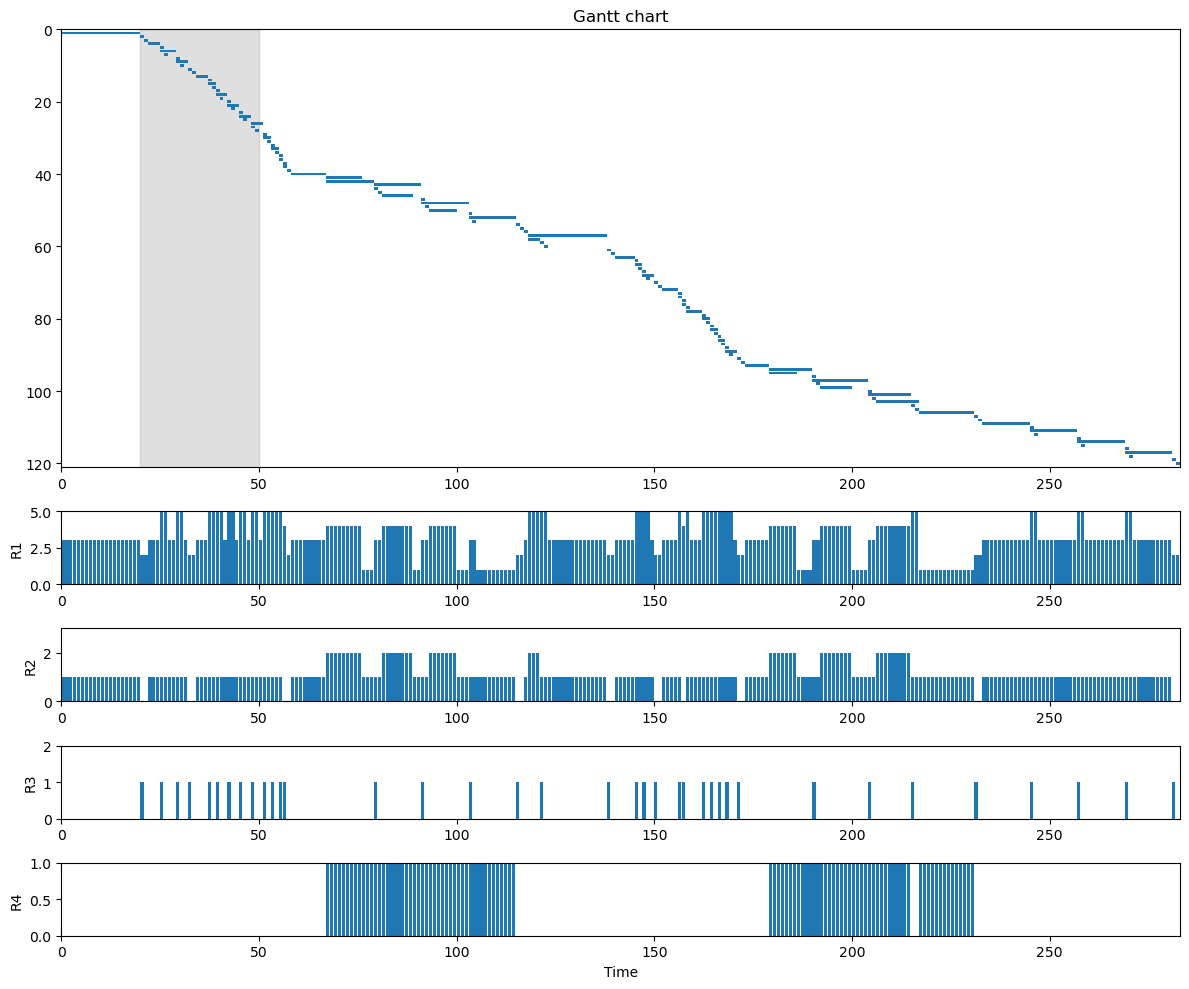

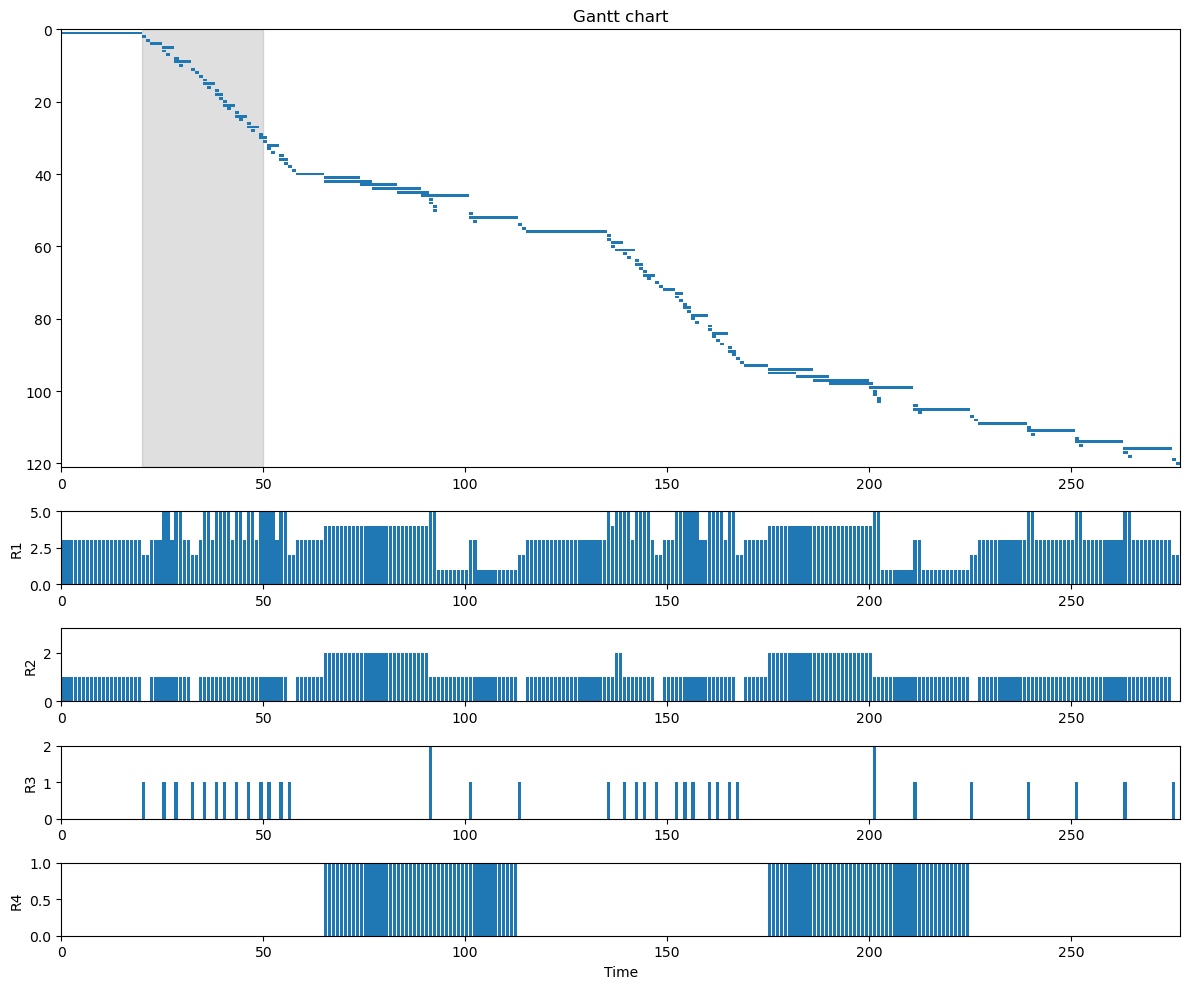

In [38]:
init_sol = RcpspState(list(range(instance.num_jobs)))
x = init_sol.objective()
print(f"Initial solution has objective {init_sol.objective()}.")
init_sol.plot()

rnd_state = rnd.RandomState(SEED)

alns = ALNS(rnd_state)

alns.add_destroy_operator(most_mobile_removal)
alns.add_destroy_operator(non_peak_removal)
alns.add_destroy_operator(segment_removal)

alns.add_repair_operator(random_insert)
crit = HillClimbing()
weights = SegmentedWeights(WEIGHTS, 3, 1, THETA, SEG_LENGTH)

res = alns.iterate(init_sol, weights, crit, iterations=ITERS)
sol = res.best_state
sol.plot()

print(f"Heuristic solution has objective {sol.objective()}.")